In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot

import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Flatten, Dense, Dropout
 

# 【問題1】公式チュートリアルモデルを分担して実行

### 画像セグメンテーション

In [2]:
import tensorflow as tf

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

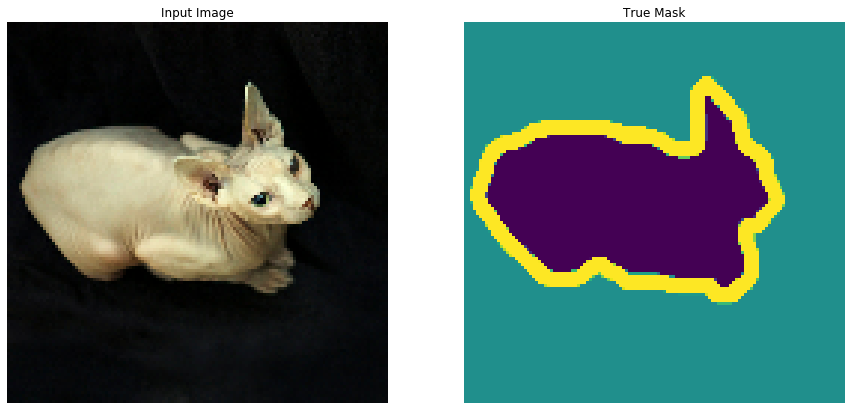

In [12]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [13]:
OUTPUT_CHANNELS = 3

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

        # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
import pydot
import graphviz

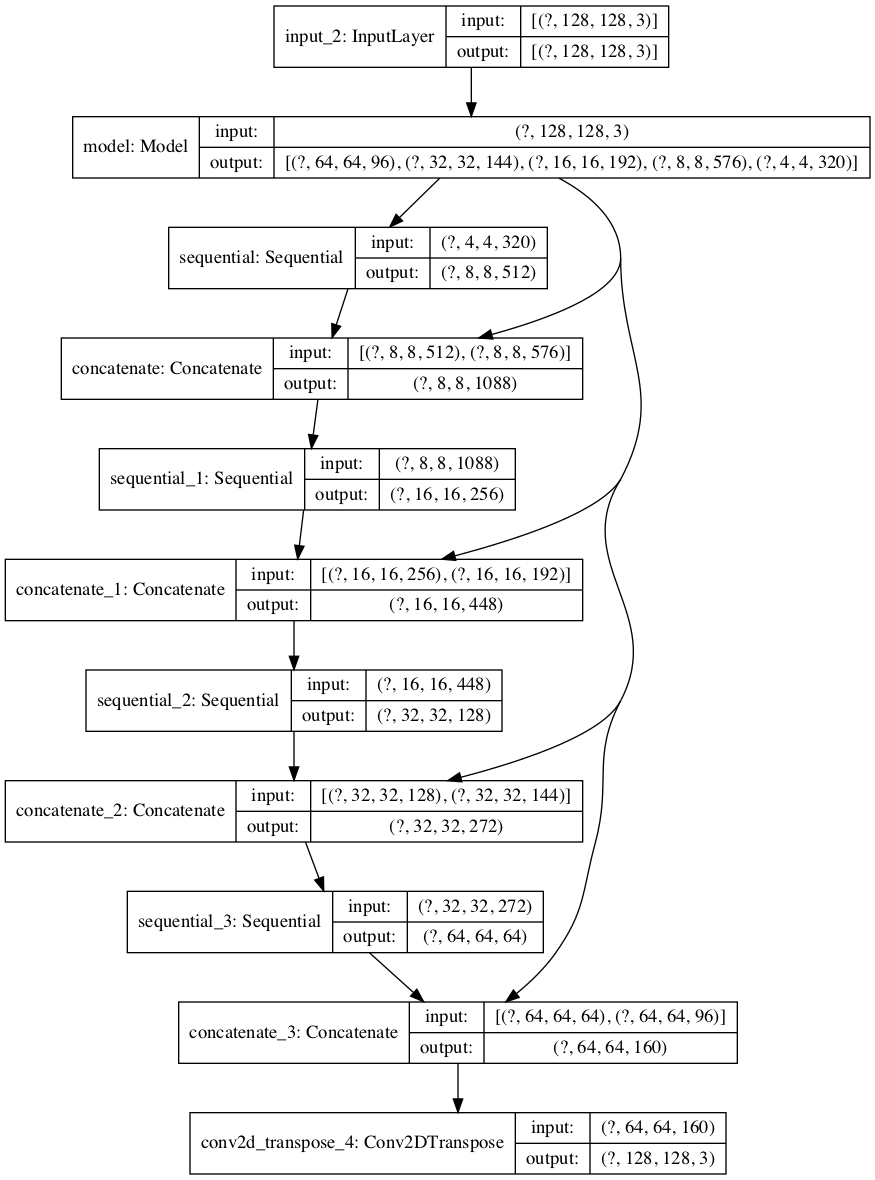

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [178]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

この先の実行はメモリ足りなくなるので、GoogleColabで試してみます。

この先もあるが、それを実行するとjupyter死んでしまうので行いません。

# 【問題2】（アドバンス課題）様々な手法を実行
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。


なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。

# 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [179]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
from sklearn.datasets import load_iris
iris_data = load_iris()
X = iris_data.data[50:]
y = iris_data.target[50:] - 1
print(y.shape)
y = y.astype(np.int)[:, np.newaxis]
print(y.shape)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

(100,)
(100, 1)


In [180]:
print(X_train.shape)
print(y_train.shape)

(64, 4)
(64, 1)


In [182]:
model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Dense(256, input_dim=4, activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(Dense(128, activation="relu", kernel_initializer="uniform"))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_54 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_55 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 42,497
Trainable params: 42,497
Non-trainable params: 0
_________________________________________________________________


In [183]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [184]:
history = model.fit(X_train, y_train, nb_epoch=100, batch_size=20, validation_data=(X_val, y_val))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 64 samples, validate on 16 samples
Epoch 1/100
64/64 [==============================] - 1s 21ms/step - loss: 0.6922 - accuracy: 0.5312 - val_loss: 0.6969 - val_accuracy: 0.3750
Epoch 2/100
64/64 [==============================] - 0s 390us/step - loss: 0.6901 - accuracy: 0.5312 - val_loss: 0.6965 - val_accuracy: 0.3750
Epoch 3/100
64/64 [==============================] - 0s 437us/step - loss: 0.6897 - accuracy: 0.5312 - val_loss: 0.7005 - val_accuracy: 0.3750
Epoch 4/100
64/64 [==============================] - 0s 332us/step - loss: 0.6862 - accuracy: 0.5312 - val_loss: 0.7018 - val_accuracy: 0.3750
Epoch 5/100
64/64 [==============================] - 0s 449us/step - loss: 0.6844 - accuracy: 0.5312 - val_loss: 0.7017 - val_accuracy: 0.3750
Epoch 6/100
64/64 [==============================] - 0s 392us/step - loss: 0.6822 - accuracy: 0.5312 - val_loss: 0.7062 - val_accuracy: 0.3750
Epoch 7/100
64/64 [==============================] - 0s 392us/step - loss: 0.6800 - accuracy: 0.531

64/64 [==============================] - 0s 391us/step - loss: 0.0852 - accuracy: 0.9688 - val_loss: 0.0603 - val_accuracy: 0.9375
Epoch 58/100
64/64 [==============================] - 0s 406us/step - loss: 0.0782 - accuracy: 0.9531 - val_loss: 0.0346 - val_accuracy: 1.0000
Epoch 59/100
64/64 [==============================] - 0s 393us/step - loss: 0.0810 - accuracy: 0.9688 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 60/100
64/64 [==============================] - 0s 353us/step - loss: 0.0700 - accuracy: 0.9844 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 61/100
64/64 [==============================] - 0s 377us/step - loss: 0.0646 - accuracy: 0.9844 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 62/100
64/64 [==============================] - 0s 385us/step - loss: 0.0600 - accuracy: 0.9688 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 63/100
64/64 [==============================] - 0s 414us/step - loss: 0.0639 - accuracy: 0.9844 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch

In [185]:
# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))

20/20 [==============================] - 0s 77us/step
evaluate loss: 0.12917713820934296
evaluate acc: 0.949999988079071


# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [194]:
# データセットの読み込み
from sklearn.datasets import load_iris
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:, np.newaxis])

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [195]:
model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Dense(256, input_dim=4, activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(Dense(128, activation="relu", kernel_initializer="uniform"))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(3, activation="softmax", kernel_initializer="normal"))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 195       
Total params: 42,627
Trainable params: 42,627
Non-trainable params: 0
_________________________________________________________________


In [196]:
history = model.fit(X_train, y_train, batch_size=10, verbose=1, epochs=30,validation_data=(X_val, y_val))

Train on 96 samples, validate on 24 samples
Epoch 1/30
96/96 [==============================] - 1s 10ms/step - loss: 1.0946 - accuracy: 0.3542 - val_loss: 1.0762 - val_accuracy: 0.3750
Epoch 2/30
96/96 [==============================] - 0s 538us/step - loss: 1.0683 - accuracy: 0.3646 - val_loss: 1.0356 - val_accuracy: 0.3750
Epoch 3/30
96/96 [==============================] - 0s 513us/step - loss: 1.0087 - accuracy: 0.5000 - val_loss: 0.9343 - val_accuracy: 0.7083
Epoch 4/30
96/96 [==============================] - 0s 593us/step - loss: 0.8716 - accuracy: 0.6875 - val_loss: 0.7552 - val_accuracy: 0.7083
Epoch 5/30
96/96 [==============================] - 0s 557us/step - loss: 0.6789 - accuracy: 0.6875 - val_loss: 0.5548 - val_accuracy: 0.7083
Epoch 6/30
96/96 [==============================] - 0s 553us/step - loss: 0.4879 - accuracy: 0.6875 - val_loss: 0.4282 - val_accuracy: 0.8333
Epoch 7/30
96/96 [==============================] - 0s 577us/step - loss: 0.3946 - accuracy: 0.9062 - val

In [197]:
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))

30/30 [==============================] - 0s 87us/step
evaluate loss: 0.03333102911710739
evaluate acc: 0.9666666388511658


# 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [212]:
df = pd.read_csv('train.csv')
X = df[['GrLivArea', 'YearBuilt']]
y = df.SalePrice[:, np.newaxis]

y = np.log(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std



# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train.shape

(934, 2)

In [213]:
model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Dense(256, input_dim=2, activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(Dense(128, activation="relu", kernel_initializer="uniform"))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(1))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_82 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_83 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 65        
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________


In [214]:
history = model.fit(X_train, y_train, batch_size=10, verbose=1, epochs=20)

Epoch 1/20
934/934 [==============================] - 1s 1ms/step - loss: 42.8846 - mae: 4.7398
Epoch 2/20
934/934 [==============================] - 0s 409us/step - loss: 0.9856 - mae: 0.6710
Epoch 3/20
934/934 [==============================] - 0s 419us/step - loss: 0.2701 - mae: 0.3437
Epoch 4/20
934/934 [==============================] - 0s 414us/step - loss: 0.1511 - mae: 0.2673
Epoch 5/20
934/934 [==============================] - 0s 422us/step - loss: 0.0918 - mae: 0.2096
Epoch 6/20
934/934 [==============================] - 0s 409us/step - loss: 0.0752 - mae: 0.2016
Epoch 7/20
934/934 [==============================] - 0s 416us/step - loss: 0.0722 - mae: 0.1943
Epoch 8/20
934/934 [==============================] - 0s 414us/step - loss: 0.0621 - mae: 0.1827
Epoch 9/20
934/934 [==============================] - 0s 420us/step - loss: 0.0624 - mae: 0.1844
Epoch 10/20
934/934 [==============================] - 0s 417us/step - loss: 0.0616 - mae: 0.1814
Epoch 11/20
934/934 [=========

In [215]:
# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate mae: {0[1]}".format(score))

292/292 [==============================] - 0s 417us/step
evaluate loss: 0.06557292419753663
evaluate mae: 0.17943349480628967


# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [224]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape

(48000, 28, 28, 1)

In [225]:
model = Sequential()
# 入力ユニット数は4（特徴量）, 1つ目の全結合層の出力ユニット数は256
model.add(Conv2D(128, input_shape=(28, 28, 1), kernel_size=(3, 3), activation="relu", kernel_initializer="uniform"))

# 2つ目の全結合層（隠れ層）の出力ユニット数は128。活性化関数はrelu。
model.add(MaxPool2D(pool_size=(2, 2)))

# 3つ目の全結合層（隠れ層）の出力ユニット数は64。活性化関数はrelu。
model.add(Flatten())

# 4つ目の全結合層（出力層）の出力ユニット数は1
model.add(Dense(10, activation="softmax", kernel_initializer="normal"))


# 学習処理設定
## 損失関数(誤差関数)：多クラス多ラベル分類, 最適化アルゴリズム：確率的勾配降下法, 評価関数：正解率
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_87 (Dense)             (None, 10)                216330    
Total params: 217,610
Trainable params: 217,610
Non-trainable params: 0
_________________________________________________________________


In [226]:
history = model.fit(X_train, y_train, batch_size=20, verbose=1, epochs=3)

Epoch 1/3
48000/48000 [==============================] - 44s 917us/step - loss: 0.1711 - accuracy: 0.9490
Epoch 2/3
48000/48000 [==============================] - 42s 882us/step - loss: 0.0639 - accuracy: 0.9810
Epoch 3/3
48000/48000 [==============================] - 43s 893us/step - loss: 0.0466 - accuracy: 0.9859


In [227]:
# モデルの評価
score = model.evaluate(X_test, y_test, verbose=True)
print("evaluate loss: {0[0]}\nevaluate acc: {0[1]}".format(score))

10000/10000 [==============================] - 2s 206us/step
evaluate loss: 0.06105422289995477
evaluate acc: 0.9801999926567078


## 自主課題　keras functional API での表記方法

### keras functional APIとは
functional APIは，複数の出力があるモデルや有向非巡回グラフ，共有レイヤーを持ったモデルなどの複雑なモデルを定義するためのインターフェースです
複雑なモデルを作るときに利用できる。
ひとまずtensorflowのチュートリアルに沿って実行

In [231]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()

In [234]:
inputs = keras.Input(shape=(784,))

In [235]:
dense = layers.Dense(64,activation='relu')
x = dense(inputs)

x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

In [237]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


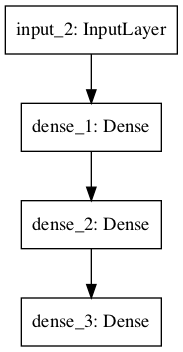

In [239]:
keras.utils.plot_model(model, 'my_first_model.png')

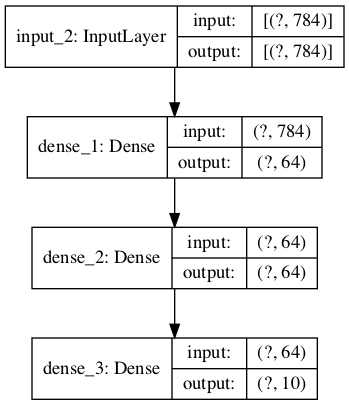

In [241]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

In [243]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test = X_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer = keras.optimizers.RMSprop(),
                          metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=20, epochs=3, validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('loss:', test_scores[0])
print('acc:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 13s 269us/sample - loss: 0.2857 - accuracy: 0.9169 - val_loss: 0.1598 - val_accuracy: 0.9542
Epoch 2/3
48000/48000 [==============================] - 12s 247us/sample - loss: 0.1383 - accuracy: 0.9592 - val_loss: 0.1257 - val_accuracy: 0.9639
Epoch 3/3
48000/48000 [==============================] - 12s 249us/sample - loss: 0.1050 - accuracy: 0.9701 - val_loss: 0.1196 - val_accuracy: 0.9681
10000/1 - 1s - loss: 0.0581 - accuracy: 0.9692
loss: 0.11127185571532464
acc: 0.9692


In [245]:
model.save('path_to_my_model')
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model('path_to_my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: path_to_my_model/assets


INFO:tensorflow:Assets written to: path_to_my_model/assets


### 畳み込み　functional API

In [270]:
from keras import backend as K
K.clear_session

<function keras.backend.tensorflow_backend.clear_session()>

In [350]:
encoder_input = keras.Input(shape=(28,28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 16)                0   

In [351]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 16)                0   

# 【問題7】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

In [338]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

In [339]:
from sklearn.datasets import load_digits
from sklearn import datasets, model_selection
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

In [340]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [341]:
# 訓練用テンソル
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
# テスト用テンソル
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [342]:
X_train = X_train.reshape((len(X_train), 1, 28, 28))
X_test = X_test.reshape((len(X_test), 1, 28, 28))

In [343]:
train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=20, shuffle=True)

In [344]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #　畳み込み層
        self.conv1 = nn.Conv2d(1, 6, 5) # 入力チャネル数、出力チャネル数、フィルタサイズ
        self.conv2 = nn.Conv2d(6, 16, 5)
        #　全結合層
        self.fc1 = nn.Linear(256, 64) # 256 = (((28-5+1)/2)-5+1)/2 * (((28-5+1)/2)-5+1)/2 *16
        self.fc2 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        #プーリング層
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # 領域サイズ
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [345]:
# インスタンスの生成
model = Net()

In [366]:
# 誤差関数のセット
criterion = nn.CrossEntropyLoss()
# 最適化関数のセット
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 学習開始
for epoch in range(3):
    total_loss = 0
    # 分割したデータの取り出し
    for X_train, y_train in train_loader:
        #計算グラフの構築
        X_train, y_train = Variable(X_train), Variable(y_train)
        #勾配をリセットする
        optimizer.zero_grad()
        #順伝播の計算
        output = model(X_train)
        #誤差の計算
        loss = criterion(output, y_train)
        #　逆伝播の計算
        loss.backward()
        #重みの更新
        optimizer.step()
        # 誤差の累積(pytorch0.4 では１次元テンソルはitem()で値の取り出し)
        total_loss += loss.item()
        
    # 累積誤差を１００回ごとに表示
    if (epoch+1) % 1 == 0:
        print(epoch+1, total_loss)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1 93.00419071300303
2 88.69172754771384
3 53.61771749061081
